In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from numpy import arange, meshgrid
from smt.sampling_methods import LHS
# Seeds
torch.manual_seed(123)
np.random.seed(123)
def train(epoch):
    model.train()
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                   
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,v_ic_train,p_ic_train)   
        loss_bdL = model.loss_bc(x_bcL_train, rho_bcL_train,u_bcL_train,v_bcL_train,p_bcL_train)   
        loss_bdR = model.loss_bc1(x_bcR_train,rho_bcR_train,u_bcR_train,v_bcR_train,p_bcR_train)   
        loss_bdI = model.bd_B(x_bcI_train, sin_bcI_train,cos_bcI_train)  

        loss_ib = loss_ic  +  loss_bdI +loss_bdL
        loss = loss_pde + 10*loss_ib

        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ib:{loss_ib:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))
def IC(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    rho1 = 2.112
    p1 =  3.011
    v1 = 0.0
    u1 = np.sqrt(1.4*p1/rho1)*0.728
    
    rho2 = 1.0
    p2 = 1.
    v2 = 0.0
    #u1 = ms*npsqrt(gamma)
    u2 = 0.0
    # rho, p - initial condition
    for i in range(N):
        if x[i,1] < 0.5:
            rho_init[i] = rho1
            u_init[i] =   u1
            v_init[i] =  v1
            p_init[i] =  p1
        else:
            rho_init[i] = rho2
            u_init[i] =   u2
            v_init[i] =  v2
            p_init[i] =  p2

    return rho_init, u_init, v_init,p_init

def BC_L(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    #u1 = ms*npsqrt(gamma)
    # rho, p - initial condition
    rho1 = 2.112
    p1 =  3.011
    v1 = 0.0
    u1 = np.sqrt(1.4*p1/rho1)*0.728
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] =  u1
        v_init[i] =  v1
        p_init[i] =  p1
    return rho_init, u_init, v_init,p_init
def BC_R(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    ms = 2.0
    rho1 = 1.0
    p1 = 1.0
    v1 = 0.0
    u1 = 0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] = u1
        v_init[i] = v1
        p_init[i] = p1

    return rho_init, u_init, v_init,p_init
def BC_Cut(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))
    u_init = np.zeros((x.shape[0]))
    v_init = np.zeros((x.shape[0]))
    p_init = np.zeros((x.shape[0]))
    
    gamma = 1.4
    ms = 2.0
    rho1 = 1.0
    p1 = 1.0
    v1 = 0.0
    u1 = 0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = 10.01
        u_init[i] =  0
        v_init[i] = 0
        p_init[i] = 10.01

    return rho_init, u_init, v_init,p_init
    
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(3, 90))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 6):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(90, 90))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(90, 4))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    def bd_B(self,x,sin,cos):
        yb = self.net(x)
        rhob,pb,ub,vb = yb[:, 0:1], yb[:, 1:2], yb[:, 2:3],yb[:,3:]
        drhob_g = gradients(rhob, x)[0]                                      # Gradient [u_t, u_x]
        rhob_x, rhob_y = drhob_g[:, 1:2], drhob_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dub_g = gradients(ub, x)[0]                                      # Gradient [u_t, u_x]
        ub_x, ub_y = dub_g[:, 1:2], dub_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dvb_g = gradients(vb, x)[0]                                      # Gradient [u_t, u_x]
        vb_x, vb_y = dvb_g[:, 1:2], dvb_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dpb_g = gradients(pb, x)[0]                                      # Gradient [p_t, p_x]
        pb_x, pb_y = dpb_g[:, 1:2], dpb_g[:, 2:3]                            # Partial derivatives p_t, p_x
        
        deltau = ub_x + vb_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        #lam = (deltau) - deltau) + 1
        
        fb = (((ub*cos + vb*sin)/lam)**2).mean() +\
            (((pb_x*cos + pb_y*sin)/lam)**2).mean() +\
            (((rhob_x*cos + rhob_y*sin)/lam)**2).mean()
        return fb
    def bd_OY(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_y)/lam)**2).mean() +\
            ((( v_y)/lam)**2).mean() +\
            ((( p_y)/lam)**2).mean() +\
            ((( rho_y)/lam)**2).mean()
        return f
    
    def bd_OX(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_x)/lam)**2).mean() +\
            ((( v_x)/lam)**2).mean() +\
            ((( p_x)/lam)**2).mean() +\
            ((( rho_x)/lam)**2).mean()
        return f
     
    # Loss function for PDE
    def loss_pde(self, x):
        
        y = self.net(x)
        gamma = 1.4                                                   
        epsilon = 1e-5
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        rhoE = p/(gamma - 1) +0.5*rho*(u**2+v**2)
        
        f1 = rho*u
        f2 = rho*u*u+p
        f3 = rho*u*v
        f4 = (rhoE+p)*u
        
        g1 = rho*v
        g2 = rho*v*u
        g3 = rho*v*v + p
        g4 = (rhoE+p)*v
        
        drho_g = gradients(rho,x)[0]
        U1_t = drho_g[:, :1]
        dU2_g = gradients(f1,x)[0]
        U2_t = dU2_g[:, :1]
        dU3_g = gradients(g1,x)[0]
        U3_t = dU3_g[:, :1]
        dU4_g = gradients(rhoE,x)[0]
        U4_t = dU4_g[:, :1]
        
        df1_g = gradients(f1, x)[0]                                  
        f1_x = df1_g[:, 1:2]
        df2_g = gradients(f2, x)[0]                                  
        f2_x = df2_g[:, 1:2]
        df3_g = gradients(f3, x)[0]                                  
        f3_x = df3_g[:, 1:2]
        df4_g = gradients(f4, x)[0]                                  
        f4_x = df4_g[:, 1:2]
        
        dg1_g = gradients(g1, x)[0]                                  
        g1_y = dg1_g[:, 2:3]
        dg2_g = gradients(g2, x)[0]                                  
        g2_y = dg2_g[:, 2:3]
        dg3_g = gradients(g3, x)[0]                                  
        g3_y = dg3_g[:, 2:3]
        dg4_g = gradients(g4, x)[0]                                  
        g4_y = dg4_g[:, 2:3]
        
        
        du_g = gradients(u, x)[0]                                
        u_x = du_g[:, 1:2]         
        dv_g = gradients(v, x)[0]                    
        v_y = dv_g[:, 2:3]         
        
        d = np.random.rand()
        deltau = u_x + v_y
        nab = abs(deltau) - deltau
        
        
        d = 1.0
        lam = d*(0.1*nab) + 1
        
        f = (((U1_t + f1_x+g1_y )/lam)**2).mean() +\
            (((U2_t + f2_x+g2_y )/lam)**2).mean() +\
            (((U3_t + f3_x+g3_y )/lam)**2).mean() +\
            (((U4_t + f4_x+g4_y )/lam)**2).mean()

        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics

    def loss_bc(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics
    def loss_bc1(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() 

        return loss_ics

def BD_circle(t,xc,yc,r,n):
    x = np.zeros((n,3)) 
    sin = np.zeros((n,1)) 
    cos = np.zeros((n,1)) 

    for i in range(n):
        the = 2*np.random.rand()*np.pi
        xd = np.cos(the + np.pi/2)
        yd = np.sin(the + np.pi/2)
        x[i,0] = np.random.rand()*t
        x[i,1] = xc  + xd*r
        x[i,2] = yc  + yd*r
        cos[i,0] = xd 
        sin[i,0] = yd
    return x, sin,cos

def Pertur(x, dx):
    N =x.shape[0]
    xL = np.zeros((N,3))
    xR = np.zeros((N,3))
    xU = np.zeros((N,3))
    xD = np.zeros((N,3))
    
    for i in range(N):
        xL[i,0] = x[i,0]
        xR[i,0] = x[i,0]
        xU[i,0] = x[i,0]
        xD[i,0] = x[i,0]
        
        
        xL[i,1] = x[i,1] - dx
        xR[i,1] = x[i,1] + dx
        xU[i,1] = x[i,1]
        xD[i,1] = x[i,1]
        
        xL[i,2] = x[i,2] 
        xR[i,2] = x[i,2]
        xU[i,2] = x[i,2] + dx
        xD[i,2] = x[i,2] - dx
        
    return xL,xR,xU,xD
    
    
    
def BD_BackCorner(t,n):
    
    x = np.zeros((n,3)) 
    x2 = np.zeros((n,3)) 
    sin = np.zeros((n,1)) 
    sin2 = np.zeros((n,1)) 
    cos = np.zeros((n,1)) 
    cos2 = np.zeros((n,1)) 
    
    for i in range(n):
        x[i,0] = np.random.rand()*t
        x[i,1] = np.random.rand()*0.3 + 0.2
        x[i,2] = 1.5
        sin[i] = 1
        cos[i] = 0
    for i in range(n):
        x2[i,0] = np.random.rand()*t
        x2[i,1] = np.random.rand()*0.5
        x2[i,2] = 1.5
        sin2[i] = 1
        cos2[i] = 0
    x = np.vstack((x,x2))
    sin = np.vstack((sin,sin2))
    cos = np.vstack((cos,cos2))
    
    for i in range(n):
        x2[i,0] = np.random.rand()*t
        x2[i,1] = 0.5
        x2[i,2] = np.random.rand()*1.5
        sin2[i] = 0
        cos2[i] = 1
        
    x = np.vstack((x,x2))
    sin = np.vstack((sin,sin2))
    cos = np.vstack((cos,cos2))
    
    for i in range(n):
        x2[i,0] = np.random.rand()*t
        x2[i,1] = 0.5
        x2[i,2] = np.random.rand()*0.3 + 1.2
        sin2[i] = 0
        cos2[i] = 1
        
    x = np.vstack((x,x2))
    sin = np.vstack((sin,sin2))
    cos = np.vstack((cos,cos2))
        
    return x,sin,cos

# Solve Euler equations using PINNs
# def main():
  # Initialization
#device = torch.device('cuda')                                          # Run on CPU
device = torch.device('cuda')                                          # Run on CPU
lr = 0.001                                                           # Learning rate
num_ib = 15000                                                # Random sampled points from IC0
num_int = 200000                                                # Random sampled points in interior
Tend = 0.4
Lx = 1.5
Ly = 2.0
rx = 1.0
ry = 1.0
rd = 0.25


xlimits = np.array([[0.,Tend],[0.0, Lx], [0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)

#xlimits = np.array([[0.,Tend],[0.5, 2], [0.5,2]])  #interal
#sampling = LHS(xlimits=xlimits)
#x_int1_train = sampling(num_int)
#x_int_train =  np.vstack((x_int_train,x_int1_train))

A = []
for i in range(num_int):
    x = x_int_train[i,1]
    y = x_int_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_int_train = np.delete(x_int_train,A,axis=0)

#xlimits = np.array([[0.0, Tend], [1.0, 4.0], [0.2,1.0]])
#sampling = LHS(xlimits=xlimits)
#x_int_train_add = sampling(3*num_int)
#x_int_train = np.vstack((x_int_train,x_int_train_add))

#x_intL_train,x_intR_train,x_intU_train,x_intD_train = Pertur(x_int_train, 0.01)

xlimits = np.array([[0.,0.0],[0.0,Lx], [0.0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic_train = sampling(num_ib)
A = []
for i in range(num_ib):
    x = x_ic_train[i,1]
    y = x_ic_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_ic_train = np.delete(x_ic_train,A,axis=0)


#xlimits = np.array([[0.0, 0.0], [1.0, 4.0], [0.2,1.0]])
#sampling = LHS(xlimits=xlimits)
#x_ic_train_add = sampling(3*num_int)
#x_ic_train = np.vstack((x_ic_train,x_ic_train_add))


xlimits = np.array([[0.0,Tend],[0.0, 0.0], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcL_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [Lx, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcR_train =  sampling(num_ib)


xlimits = np.array([[0.0,Tend],[0.0, Lx], [Ly,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcU_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [0.0, Lx], [0.0,0.0]])
sampling = LHS(xlimits=xlimits)
x_bcD_train =  sampling(num_ib)                                           # Vectorized whole domain

#xlimits = np.array([[0.0,0.0],[0.0, Lx], [0.0,Ly]])
#sampling = LHS(xlimits=xlimits)
#x_ic_train =  sampling(num_ib)
#A = []
#for i in range(num_ib):
#    x = x_ic_train[i,1]
#    y = x_ic_train[i,2]
#    if ((x-rx)**2 + (y-ry)**2 ) < rd**2:
#        A.append(i)
#x_ic_train = np.delete(x_ic_train,A,axis=0)


x_bcI_train,sin_bcI_train,cos_bcI_train = BD_circle(Tend,rx,ry,rd,num_ib)
#x_bcI_train,sin_bcI_train,cos_bcI_train = BD_BackCorner(Tend,num_ib)

rho_bcL_train, u_bcL_train,v_bcL_train, p_bcL_train = BC_L(x_bcL_train)  
rho_bcR_train, u_bcR_train,v_bcR_train, p_bcR_train = BC_L(x_bcR_train)  
#rho_cut_train, u_cut_train,v_cut_train, p_cut_train = BC_Cut(x_cut_train)  
rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)  


x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
#x_intL_train = torch.tensor(x_intL_train,dtype=torch.float32).to(device)
#x_intR_train = torch.tensor(x_intR_train,dtype=torch.float32).to(device)
#x_intU_train = torch.tensor(x_intU_train,dtype=torch.float32).to(device)
#x_intD_train = torch.tensor(x_intD_train,dtype=torch.float32).to(device)

rho_bcL_train = torch.tensor(rho_bcL_train, dtype=torch.float32).to(device)
u_bcL_train = torch.tensor(u_bcL_train, dtype=torch.float32).to(device)
v_bcL_train = torch.tensor(v_bcL_train, dtype=torch.float32).to(device)
p_bcL_train = torch.tensor(p_bcL_train, dtype=torch.float32).to(device)

rho_bcR_train = torch.tensor(rho_bcR_train, dtype=torch.float32).to(device)
u_bcR_train = torch.tensor(u_bcR_train, dtype=torch.float32).to(device)
v_bcR_train = torch.tensor(v_bcR_train, dtype=torch.float32).to(device)
p_bcR_train = torch.tensor(p_bcR_train, dtype=torch.float32).to(device)

x_bcD_train = torch.tensor(x_bcD_train,requires_grad=True, dtype=torch.float32).to(device)
x_bcU_train = torch.tensor(x_bcU_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcR_train = torch.tensor(x_bcR_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcL_train = torch.tensor(x_bcL_train, dtype=torch.float32).to(device)
x_bcI_train = torch.tensor(x_bcI_train, requires_grad=True, dtype=torch.float32).to(device)
sin_bcI_train = torch.tensor(sin_bcI_train, dtype=torch.float32).to(device)
cos_bcI_train = torch.tensor(cos_bcI_train, dtype=torch.float32).to(device)

#rho_cut_train = torch.tensor(rho_cut_train, dtype=torch.float32).to(device)
#u_cut_train = torch.tensor(u_cut_train, dtype=torch.float32).to(device)
#v_cut_train = torch.tensor(v_cut_train, dtype=torch.float32).to(device)
#p_cut_train = torch.tensor(p_cut_train, dtype=torch.float32).to(device)
#x_cut_train = torch.tensor(x_cut_train, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)


#model = DNN().to(device)

#optimizer = torch.optim.LBFGS(model.parameters(),lr=lr,max_iter=500)
#rho_ic_train.clone().detach().requires_grad_(True)
#u_ic_train.clone().detach().requires_grad_(True)
# Initialize neural network

print('Start training...')

Start training...


In [2]:
model = DNN().to(device)

In [105]:
lr = 0.001
#optimizer = torch.optim.LBFGS(model.parameters(),lr=lr,max_iter=500)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_Adam,gamma=0.995)
#optimizer = torch.optim.LBFGS(model.parameters(),lr=0.5,max_iter=20)
#optimizer_LBFGS = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=50000)

In [ ]:
epochs = 1
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


In [12]:
lr = 0.0001
#optimizer = torch.optim.LBFGS(model.parameters(),lr=lr,max_iter=500)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_Adam,gamma=0.995)
#optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=10)
#optimizer_LBFGS = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=50000)

In [ ]:
epochs = 2
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


In [17]:
lr = 0.0001
#optimizer = torch.optim.LBFGS(model.parameters(),lr=lr,max_iter=500)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_Adam,gamma=0.995)
optimizer = torch.optim.LBFGS(model.parameters(),lr=1,max_iter=20)
#optimizer_LBFGS = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=50000)

In [ ]:
epochs = 10
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


In [ ]:
model_path = 'backcorner_new_3.pth'
torch.save(model.to('cpu'), model_path)

In [82]:
device1 = torch.device("cpu")
#model.load_state_dict(torch.load(PATH))
#torch.save(model,'2DRiemanncase8.pt')
#model = torch.save('backcorner.pt')

In [11]:
#model = model.load_state_dict(torch.load( 'backcorner.pt'))
model = model.to(device)

In [3]:
model_path = 'Withoushock2D_20time.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
model = model.to(device)

In [ ]:
# Evaluate on the whole computational domain
for i in range(50):
#u = to_numpy(model(x_test))
#x = to_numpy(x_test)
    x = np.linspace(0.0, 1.0, 401)                                   # Partitioned spatial axis
    y = np.linspace(0.0, 1.0, 400)                                   # Partitioned spatial axis
    t = np.linspace(0.20, 0.20, 1)                                        # Partitioned time axis
    t_grid, x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
    T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
    X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
    Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
    x_test = np.hstack((T, X, Y))                                            # Vectorized whole domain
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device1)
    u = to_numpy(model(x_test))
    #Xp,Yp = meshgrid(x,y)
    
    ue = np.zeros((401,400))
    for i in range(0,401):
        for j in range(0,400):
            ue[i,j] = u[j*400+i,3]
            
    plt.figure()
    plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,50)
    #plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.scatter(x_int_train[:,1],)
    #plt.pcolor(x[:],u[:,1])
    #plt.pcolor(x[:],u[:,2])
    ax = plt.gca()
    ax.set_aspect(1)
    plt.savefig("test_rasterization.png", dpi=150)
    plt.show()
 
    #    uo = ue.flatten()[:,None]
    #    uxy= np.hstack((X, Y,uo))                                            # Vectorized whole domain


In [ ]:
for k in range(50):
    Nd = 400
    T = 0.4/50*k
    t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
    x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
    y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
    t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
    T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
    X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
    Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
    x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    u = to_numpy(model(x_test))
    #Xp,Yp = meshgrid(x,y)
    
    
    x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
    ue = np.zeros((Nd,Nd))
    for j in range(0,Nd):
        for i in range(0,Nd):
            ue[i,j] = u[i*Nd+j,0]
            x1 = x_test[i*Nd+j,1] 
            y1 = x_test[i*Nd+j,2] 
            if ((x1 - 1.0)**2 +(y1-1.0)**2< 0.25**2):
                ue[i,j] = 0.0
                
    uo1 = ue.flatten()[:,None]
    ue = np.zeros((Nd,Nd))
    for j in range(0,Nd):
        for i in range(0,Nd):
            ue[i,j] = u[i*Nd+j,1]
            x1 = x_test[i*Nd+j,1] 
            y1 = x_test[i*Nd+j,2] 
            if ((x1 - 1.0)**2 +(y1-1.0)**2< 0.25**2):
                ue[i,j] = 0.0
    uo2 = ue.flatten()[:,None]
    ue = np.zeros((Nd,Nd))
    for j in range(0,Nd):
        for i in range(0,Nd):
            ue[i,j] = u[i*Nd+j,2]
            x1 = x_test[i*Nd+j,1] 
            y1 = x_test[i*Nd+j,2] 
            if ((x1 - 1.0)**2 +(y1-1.0)**2< 0.25**2):
                ue[i,j] = 0.0
            
    uo3 = ue.flatten()[:,None]
    ue = np.zeros((Nd,Nd))
    for j in range(0,Nd):
        for i in range(0,Nd):
            ue[i,j] = u[i*Nd+j,0]
            x1 = x_test[i*Nd+j,1] 
            y1 = x_test[i*Nd+j,2] 
            if ((x1 - 1.0)**2 +(y1-1.0)**2< 0.25**2):
                ue[i,j] = 0.0
    uo4 = ue.flatten()[:,None]
   # filename = "temp{}.dat".format(k) 
   # uxy= np.hstack((X, Y,uo1,uo2,uo3,uo4)) 
   # f = open(filename,'w')
   # f.write(var2)
   # np.savetxt(f, uxy)# Vectorized whole domain
   # f.close()

ERROR! Session/line number was not unique in database. History logging moved to new session 4837


In [10]:
Nd = 600
T = 1.0
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(model(x_test))
#Xp,Yp = meshgrid(x,y)


x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
            
uo1 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,1]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo2 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,2]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
        
uo3 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
#uo4 = ue.flatten()[:,None]
#filename = "temp{}.dat".format(44) 
#uxy= np.hstack((X, Y,uo1,uo2,uo3,uo4)) 
#f = open(filename,'w')
#f.write(var2)
#np.savetxt(f, uxy)# Vectorized whole domain
#f.close()

In [5]:
var2 = """TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT
"""

In [5]:
model

DNN(
  (net): Sequential(
    (Linear_layer_1): Linear(in_features=3, out_features=90, bias=True)
    (Tanh_layer_1): Tanh()
    (Linear_layer_2): Linear(in_features=90, out_features=90, bias=True)
    (Tanh_layer_2): Tanh()
    (Linear_layer_3): Linear(in_features=90, out_features=90, bias=True)
    (Tanh_layer_3): Tanh()
    (Linear_layer_4): Linear(in_features=90, out_features=90, bias=True)
    (Tanh_layer_4): Tanh()
    (Linear_layer_5): Linear(in_features=90, out_features=90, bias=True)
    (Tanh_layer_5): Tanh()
    (Linear_layer_6): Linear(in_features=90, out_features=90, bias=True)
    (Tanh_layer_6): Tanh()
    (Linear_layer_final): Linear(in_features=90, out_features=4, bias=True)
  )
)

In [6]:
filename = '1.dat'
with open(filename, 'r', encoding='utf-8') as fileobj:
    for line in fileobj:
        print(var2)

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"


TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"
ZONE I=         600 J=         600 F=POINT

TITLE="Euler"
 VARIABLES="x","y","rou"，"u","v","p"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 640x480 with 0 Axes>

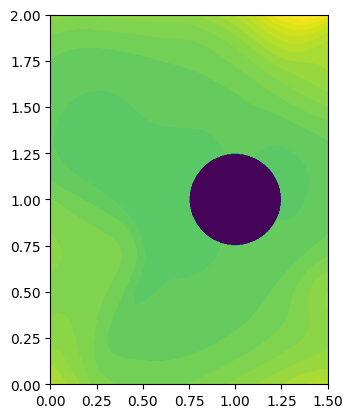

In [11]:
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
#plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.scatter(x_int_train[:,1],)
#plt.pcolor(x[:],u[:,1])
#plt.pcolor(x[:],u[:,2])
ax = plt.gca()
ax.set_aspect(1)
plt.show()
plt.savefig("Riemann2.pdf", dpi=150)


In [85]:
            #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#surf = ax.plot_surface(x_grid[:,0,:], y_grid[:,0,:], ue, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#
## Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
## A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#
## Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()

In [ ]:
xlimits = np.array([[0.,Tend],[0.0, 3], [0.0,3]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)
A = []
for i in range(num_int):
    x = x_int_train[i,1]
    y = x_int_train[i,2]
    if (x< 0.5 and y< 1.5):
        A.append(i)
x_int_train = np.delete(x_int_train,A,axis=0)

In [ ]:
plt.figure()
plt.scatter(x_int_train[1:1000,1],x_int_train[1:1000,2])
#plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.scatter(x_int_train[:,1],)
#plt.pcolor(x[:],u[:,1])
#plt.pcolor(x[:],u[:,2])
ax = plt.gca()
ax.set_aspect(1)
plt.show()

In [ ]:
torch.save(model,'2DRiemanncase8.pt')

In [ ]:
model

In [ ]:
#device1 = torch.device("cpu")
#model.load_state_dict(torch.load(PATH))
#model = model.to(device1)
#torch.save(model,'2DRiemanncase8.pt')
model = torch.load('2DRiemanncase8.pt')

In [ ]:
model